FB Prophet was created to make high quality business forecasts. 

Authors claim that _Prophet_ captures:
* Seasonal effects
* Changes in trend due to some events
* Outliers



How does it work?

First of all, _Prophet_ utilizes additive autoregression model: $y(t) = g(t) + s(t) + h(t) + \epsilon_{t}$. 

* Trend: non-periodical changes $$g(t) = \frac{C}{1+k \cdot{e^{-k(t-m)}}}$$ &nbsp;&nbsp;where $C$ - carrying capacity (max value of the curve), $k$ - growth rate (steepness  of the curve), $m$ - offset parameter. Also, $C$ and $k$ can be variables
* $s(t)$ models seasonality - periodical changes
* $h(t)$ holidays component - contributes information about holidays or events
* $\epsilon_{t}$ - error term, represents not reflected in the model information. Modelled as normally distributed noise.


# Import libraries to work with, load the data

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [39]:
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

# Initialize plotly
init_notebook_mode(connected=True)

In [48]:
from fbprophet import Prophet

import logging

In [2]:
df = pd.read_csv("data/medium_posts.csv")

drop column `domain`, as it it useless. Drop `nan` values. Get rid of duplicates. Convert `published` to datetime format and sort by time.

In [3]:
df = df.dropna(subset=['published', 'url']).drop_duplicates()
df.drop(columns='domain', inplace=True)

In [4]:
df['published'] = pd.to_datetime(df['published'])

Quick look at the data:

In [5]:
pd.concat([df.sort_values(by=['published']).head(3),df.tail(4).sort_values(by=['published']), df.sort_values(by=['published']).tail(3)])

,published,url
50931,1970-01-01 00:00:00.001,https://medium.com/iiot
40243,1970-01-01 00:00:00.001,https://medium.com/@ikaella/melon-rebranding-b...
37395,1970-01-18 05:11:46.500,http://www.novosti.rs/%D0%B2%D0%B5%D1%81%D1%82...
92187,2017-01-31 09:59:12.316,https://medium.com/silent-protagonist/next-wee...
92188,2017-02-16 14:15:20.116,https://medium.com/@utapartment26/there-used-t...
92190,2017-06-12 06:49:29.954,https://medium.com/silent-protagonist/assassin...
92189,2017-06-27 10:16:21.668,https://medium.com/silent-protagonist/the-snes...
89538,2017-06-27 12:16:47.649,https://medium.com/blog-do-andre-sobreiro/di%C...
90927,2017-06-27 13:01:27.795,https://medium.com/@AdsNative/pocketmath-reduc...
90673,2017-06-27 14:48:42.850,https://medium.com/@charliedeets/thoughts-on-t...


In [6]:
len(df[df['published'] < '2012-08-15']) * 100 / len(df)

0.142111714995498

There are a few posts, that have publishment date before the Medium's release. So, we drop these data. C'mon, there is only 0.14% of our data.

In [7]:
df = df[df['published'] > '2012-08-15'].sort_values(by='published')

In [8]:
pd.concat([df.head(10), df.tail(10)])

,published,url
24630,2012-08-15 00:25:03.373,https://medium.com/launch-day/jean-attempts-to...
24631,2012-08-15 00:25:29.419,https://medium.com/launch-day/dan-and-kristin-...
17811,2012-08-15 00:34:59.502,https://medium.com/i-m-h-o/the-world-is-social...
17281,2012-08-15 00:40:10.773,https://medium.com/@karen/this-farm-table-1cfc...
12376,2012-08-15 00:58:25.898,https://medium.com/@hattmodgins/lighting-strik...
27067,2012-08-15 01:06:36.033,https://medium.com/i-m-h-o/we-could-make-histo...
29563,2012-08-15 06:30:24.859,https://medium.com/@kvanscha/antelope-island-u...
15530,2012-08-15 14:14:14.869,https://medium.com/@zephoria/playing-with-lion...
24759,2012-08-15 14:53:37.351,https://medium.com/@zefrank/south-island-nz-ne...
30320,2012-08-15 16:50:58.729,https://medium.com/@chriserwin/the-catacombs-o...


Do some visualization:

In [36]:
# Count of days, how many Medium exists
days = (df['published'].iloc[-1] - df['published'].iloc[0]).days

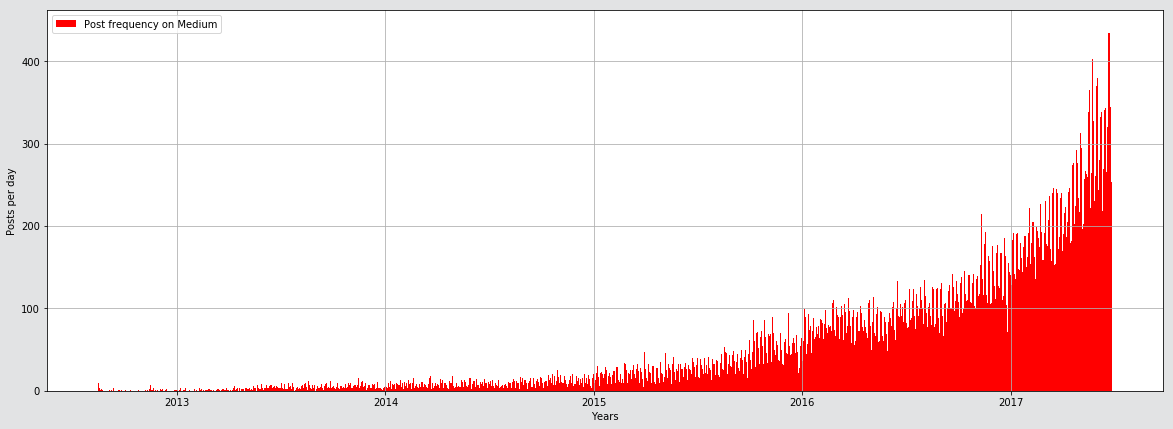

In [28]:
plt.figure(figsize=(20,7), facecolor='#e2e3e4')
plt.grid(True)
plt.xlabel('Years')
plt.ylabel('Posts per day')
plt.hist(df['published'], days, color='r')
plt.legend(['Post frequency on Medium']);

We are going to predict the number of published posts, so let's aggregate and count unique posts at each given point of time. That's why create column `posts`:

In [32]:
common_df = df.groupby('published')[['url']].count()
common_df.columns = ['posts']

In [43]:
daily_df.head()

,posts
published,
2012-08-15,16
2012-08-16,11
2012-08-17,4
2012-08-18,2
2012-08-19,1


Now there is a dataframe with the timestamp for the every new post. We have to figure out a solution to get the number of posts per day. How can we do it? - Resample! Pay attention, to that all resampled rows have summed.

In [34]:
daily_df = common_df.resample('D').apply('sum')

In [44]:
def plotly_df(dataframe, title=''):
    """
    Advanced visualizations with plotly. Visualize all the dataframe columns as line plots
    """
    common_kwargs = dict(x=dataframe.index, mode='lines')
    data = [go.Scatter(y=dataframe[c], name=c, **common_kwargs) for c in dataframe.columns]
    
    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    
    iplot(fig, show_link=False)

In [45]:
plotly_df(daily_df, title='Daily posts of Medium (with plotly)')

The data is difficult to analyze, as it is high-frequency. How to reduce the noise? 
* resample the post counts down to weekly bins
* Moving-Average smoothing
* Exponential smoothing

In [47]:
weekly_df = daily_df.resample('W').apply(sum)

plotly_df(weekly_df, title='Posts on Medium (weekly)')

# Time Series forecasting

Create a model, call a `fit` method, make a forecast. Sounds too simple

In [49]:
df = daily_df.reset_index()
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2012-08-15,16
1,2012-08-16,11
2,2012-08-17,4
3,2012-08-18,2
4,2012-08-19,1


We have to somehow measure the accuracy of the forecast. So let's split the dataset into the train and test parts. 

In [50]:
prediction_size = 30
train_df = df[:-prediction_size]
train_df.tail(n=3)

,ds,y
1745,2017-05-26,269
1746,2017-05-27,157
1747,2017-05-28,172


In [52]:
m = Prophet()
m.fit(train_df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [57]:
future_forecast = m.make_future_dataframe(periods=prediction_size)

pd.concat([future_forecast.head(2), future_forecast.tail(2)])

,ds
0,2012-08-15
1,2012-08-16
1776,2017-06-26
1777,2017-06-27


In [59]:
forecast = m.predict(future_forecast)
forecast.tail(n=4)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1774,2017-06-24,241.040014,202.411597,248.502387,240.912702,241.124208,-15.901832,-15.901832,-15.901832,-18.390615,-18.390615,-18.390615,2.488783,2.488783,2.488783,0.0,0.0,0.0,225.138182
1775,2017-06-25,241.473290,206.061856,251.070680,241.336718,241.576033,-14.143286,-14.143286,-14.143286,-16.671745,-16.671745,-16.671745,2.528459,2.528459,2.528459,0.0,0.0,0.0,227.330004
1776,2017-06-26,241.906566,229.151481,275.359075,241.757861,242.023070,10.136393,10.136393,10.136393,7.586318,7.586318,7.586318,2.550075,2.550075,2.550075,0.0,0.0,0.0,252.042960
1777,2017-06-27,242.339842,230.181848,278.227715,242.180304,242.474117,11.906711,11.906711,11.906711,9.354903,9.354903,9.354903,2.551808,2.551808,2.551808,0.0,0.0,0.0,254.246553


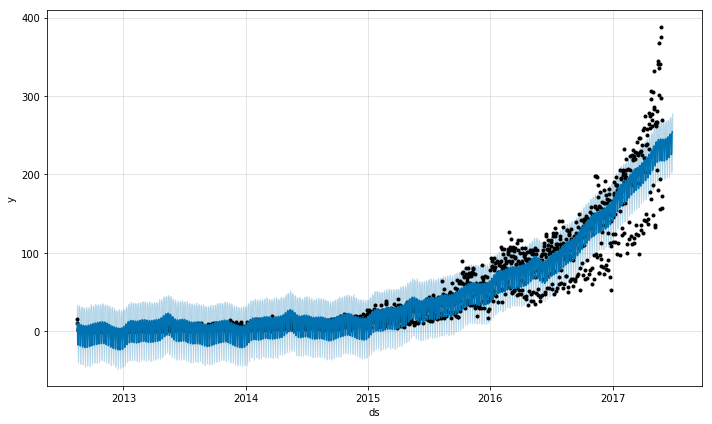

In [61]:
m.plot(forecast);

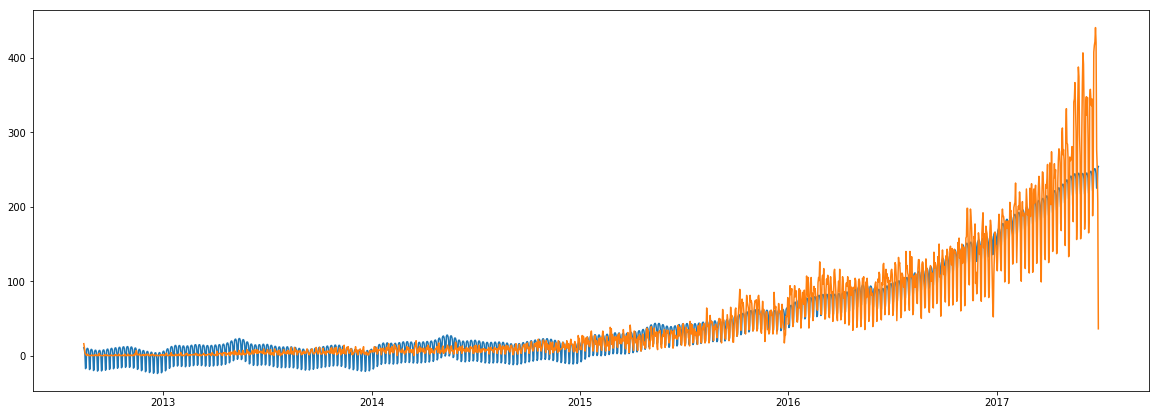

In [65]:
plt.figure(figsize=(20,7))
plt.plot(forecast['ds'], forecast['yhat'])
plt.plot(forecast['ds'], df['y'])